In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import shutil

In [16]:
asd = {"asd": 10, "qwe": 12}
asd["qwe"]

12

In [2]:
# Set working directory to home
os.chdir("/Users/giorgioclauser/Projects/covid_ita/")

In [3]:
# Remove old plots and create directory for new ones
dir_path = "/Users/giorgioclauser/Documents/covid_plts/lombardia"
shutil.rmtree(dir_path)
os.mkdir(dir_path)

In [4]:
# Import national data
df_reg = pd.read_csv("https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv")

In [6]:
df_reg.denominazione_regione.value_counts()

Calabria                 221
Valle d'Aosta            221
Sicilia                  221
Umbria                   221
Lombardia                221
P.A. Trento              221
P.A. Bolzano             221
Liguria                  221
Abruzzo                  221
Lazio                    221
Campania                 221
Piemonte                 221
Veneto                   221
Marche                   221
Puglia                   221
Friuli Venezia Giulia    221
Toscana                  221
Emilia-Romagna           221
Sardegna                 221
Molise                   221
Basilicata               221
Name: denominazione_regione, dtype: int64

In [7]:
df_reg = df_reg.loc[df_reg['denominazione_regione']=="Valle d'Aosta"].copy()

In [9]:
# Feature engineering
df_reg["prcn_tamponi_positivi_overall"] = df_reg["totale_casi"]/df_reg["tamponi"]
df_reg["prcn_tamponi_positivi_daily"] = df_reg["variazione_totale_positivi"]/(df_reg["tamponi"] - df_reg["tamponi"].shift(1))
df_reg['reference_day'] = df_reg.data.apply(lambda x: x[5:10])
df_reg['nuovi_positivi'] = df_reg['totale_positivi'] - df_reg["totale_positivi"].shift(1)
df_reg["growth_rate"] = df_reg["totale_positivi"]/df_reg["totale_positivi"].shift(1)

In [10]:
df_reg.reset_index(inplace=True)
df_reg.tail()

,index,data,stato,codice_regione,denominazione_regione,lat,long,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,...,casi_da_sospetto_diagnostico,casi_da_screening,totale_casi,tamponi,casi_testati,note,prcn_tamponi_positivi_overall,prcn_tamponi_positivi_daily,reference_day,growth_rate
216,4555,2020-09-27T17:00:00,ITA,2,Valle d'Aosta,45.737503,7.320149,3,0,3,...,1168.0,131.0,1299,28662,19826.0,NaN,0.045321,0.000000,09-27,1.000000
217,4576,2020-09-28T17:00:00,ITA,2,Valle d'Aosta,45.737503,7.320149,3,0,3,...,1169.0,131.0,1300,28765,19888.0,NaN,0.045194,-0.009709,09-28,0.984848
218,4597,2020-09-29T17:00:00,ITA,2,Valle d'Aosta,45.737503,7.320149,4,0,4,...,1176.0,132.0,1308,28926,19979.0,NaN,0.045219,0.024845,09-29,1.061538
219,4618,2020-09-30T17:00:00,ITA,2,Valle d'Aosta,45.737503,7.320149,6,0,6,...,1181.0,133.0,1314,29126,20125.0,NaN,0.045114,0.030000,09-30,1.086957
220,4639,2020-10-01T17:00:00,ITA,2,Valle d'Aosta,45.737503,7.320149,7,0,7,...,1182.0,133.0,1315,29380,20265.0,NaN,0.044758,-0.023622,10-01,0.920000


## Parametri

In [11]:
# Giorni con decreti:
fase2 = ['05-04']
fase3 = ['06-03']

# Intervallo etichette giorni
n_label = 14

## Grafici

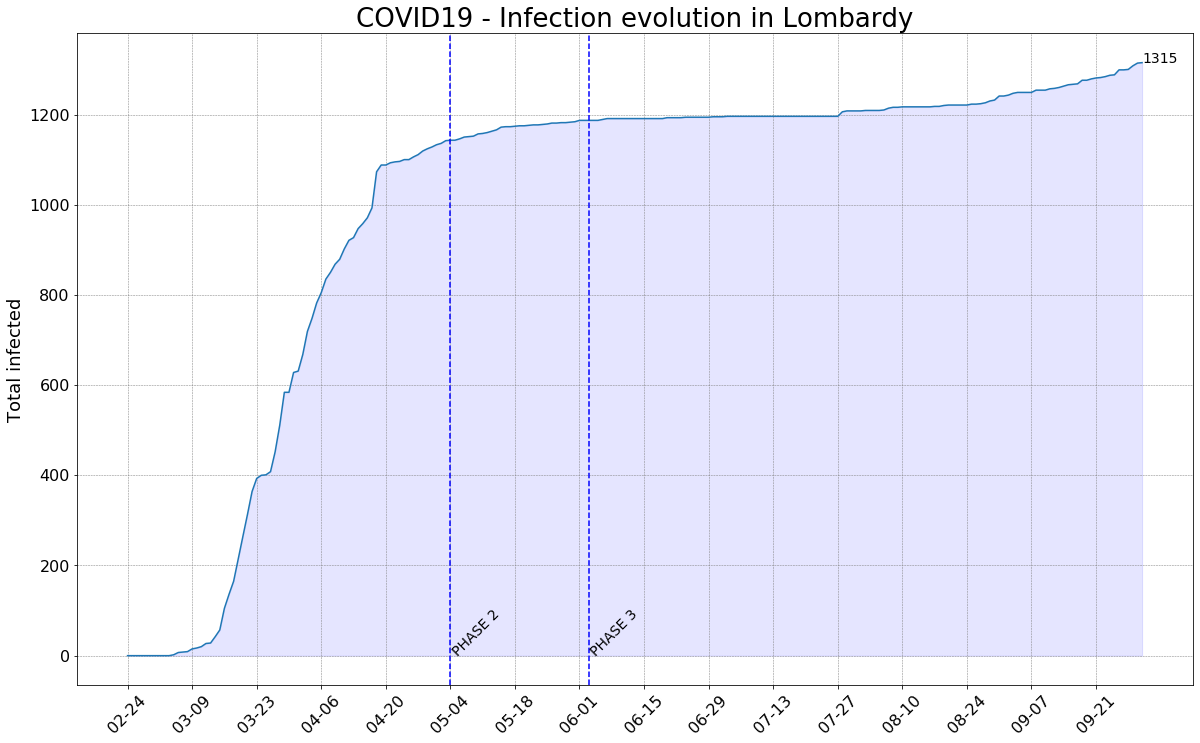

In [12]:
# Generate plot
plt.figure(figsize=(20,12))
ax = sns.lineplot(x="reference_day", y="totale_casi",
                  data=df_reg)
plt.fill_between(x='reference_day', y1='totale_casi', y2=0 ,data=df_reg, color='blue', alpha=.1)
plt.grid(color='grey', linestyle='--', linewidth=.5, which='both')
plt.ylabel('Total infected', fontsize=18)
plt.xlabel('')
plt.title('COVID19 - Infection evolution in Lombardy', fontsize=26)
ax.tick_params(axis='both', which='major', labelsize=16)
plt.xticks(rotation=45)
plt.text(df_reg.reference_day[len(df_reg)-1], 
         df_reg.totale_casi[len(df_reg)-1],
         df_reg.totale_casi[len(df_reg)-1], fontsize=14)
for day in fase2:
    ax.axvline(day, ls='--', color='blue', lw=1.5)
    plt.text(day, .3,'PHASE 2', fontsize=14, rotation=45)
for day in fase3:
    ax.axvline(day, ls='--', color='blue', lw=1.5)
    plt.text(day, .3,'PHASE 3', fontsize=14, rotation=45)
ax.set_xticks(ax.get_xticks()[::n_label])
plt.savefig(f"{dir_path}/infection_evolution_lmb.png")
plt.show()

In [10]:
def get_trend(series):
    from pandas import datetime
    from sklearn.linear_model import LinearRegression
    from matplotlib import pyplot
    import numpy
     
    def parser(x):
        return datetime.strptime('190'+x, '%Y-%m')
     
    series = series.dropna()
    # fit linear model
    X = [i for i in range(0, len(series))]
    X = numpy.reshape(X, (len(X), 1))
    y = series.values
    model = LinearRegression()
    model.fit(X, y)
    # calculate trend
    trend = model.predict(X)
    return trend

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  


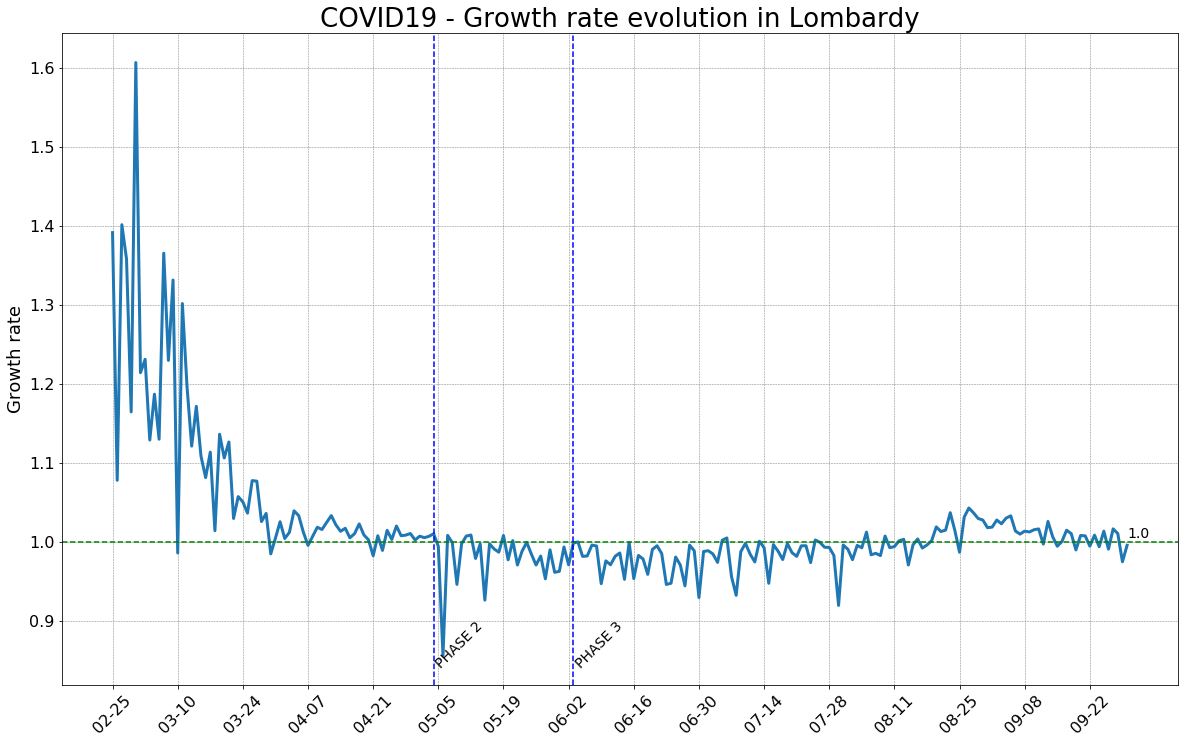

In [14]:
# Generate plot
df_gr = df_reg[["reference_day", "growth_rate"]].dropna().copy()
df_gr["growth_rate"] = df_gr.growth_rate.rolling(window=4).mean()
df_gr.dropna(inplace=True)
df_gr = df_reg[["reference_day", "growth_rate"]].dropna().copy()
df_gr["trend"] = get_trend(df_gr["growth_rate"])
plt.figure(figsize=(20,12))
ax = sns.lineplot(x="reference_day", y="growth_rate",
                  data=df_gr, lw=3)
#ax = sns.lineplot(x="reference_day", y="trend",
#                  data=df_gr, lw=2)
plt.grid(color='grey', linestyle='--', linewidth=.5, which='both')
plt.ylabel('Growth rate', fontsize=18)
plt.xlabel('')
plt.title('COVID19 - Growth rate evolution in Lombardy', fontsize=26)
ax.tick_params(axis='both', which='major', labelsize=16)
plt.xticks(rotation=45)
#plt.ylim(bottom=-2, top=5)
ax.axhline(1, ls='--', color='green', lw=1.5)
plt.text(df_gr.reference_day[len(df_gr)], 
         df_gr.growth_rate[len(df_gr)]+0.01,
         round(df_gr.growth_rate[len(df_gr)],2), fontsize=14)
for day in fase2:
    ax.axvline(day, ls='--', color='blue', lw=1.5)
    plt.text(day, .84,'PHASE 2', fontsize=14, rotation=45)
for day in fase3:
    ax.axvline(day, ls='--', color='blue', lw=1.5)
    plt.text(day, .84,'PHASE 3', fontsize=14, rotation=45)
ax.set_xticks(ax.get_xticks()[::n_label])
plt.savefig(f"{dir_path}/growth_rate_lmb.png")
plt.show()

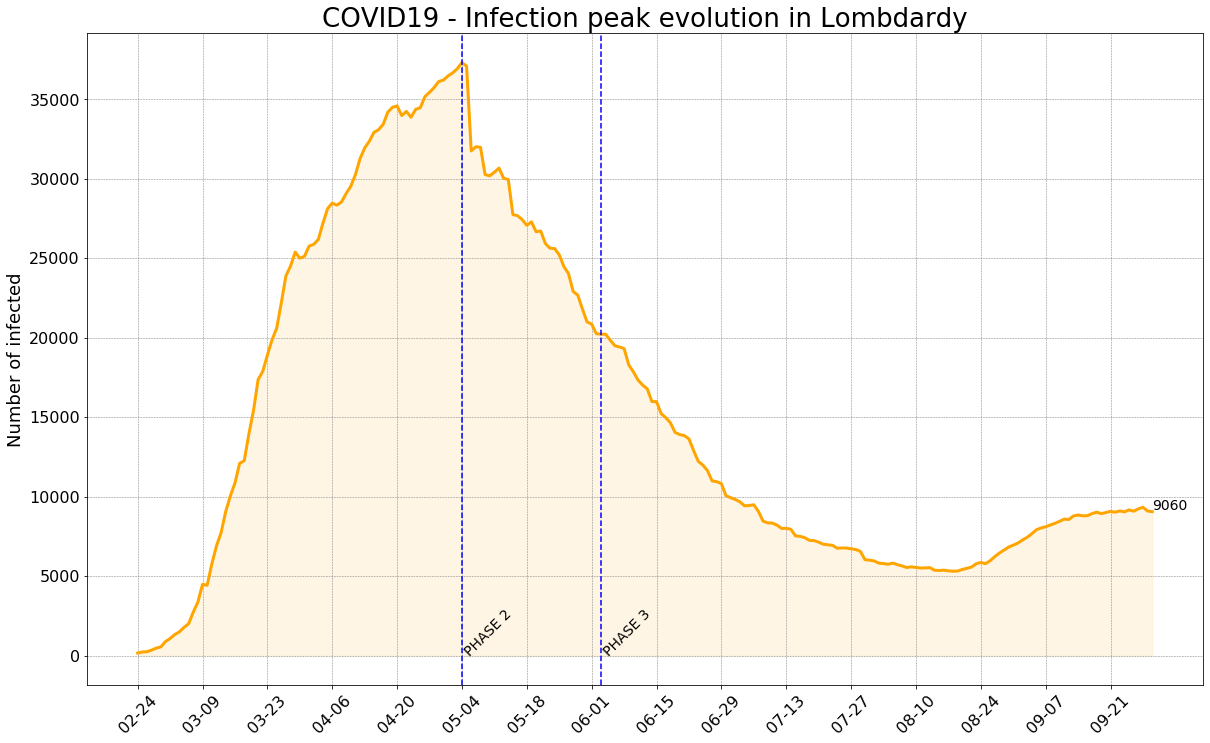

In [12]:
# What does the peak look like?
plt.figure(figsize=(20,12))
ax = sns.lineplot(x="reference_day", y="totale_positivi",
                  data=df_reg, lw=3, color='orange')
plt.grid(color='grey', linestyle='--', linewidth=.5, which='both')
plt.fill_between(x='reference_day', y1='totale_positivi', y2=0 ,data=df_reg, color='orange', alpha=.1)
plt.ylabel('Number of infected', fontsize=18)
plt.xlabel('')
plt.title('COVID19 - Infection peak evolution in Lombdardy', fontsize=26)
ax.tick_params(axis='both', which='major', labelsize=16)
plt.xticks(rotation=45)
plt.text(df_reg.reference_day[len(df_reg)-1], 
         df_reg.totale_positivi[len(df_reg)-1]+144,
         df_reg.totale_positivi[len(df_reg)-1], fontsize=14)
for day in fase2:
    ax.axvline(day, ls='--', color='blue', lw=1.5)
    plt.text(day, .3,'PHASE 2', fontsize=14, rotation=45)
for day in fase3:
    ax.axvline(day, ls='--', color='blue', lw=1.5)
    plt.text(day, .3,'PHASE 3', fontsize=14, rotation=45)
ax.set_xticks(ax.get_xticks()[::n_label])
plt.savefig(f"{dir_path}/peak_evolution_lmb.png")
plt.show()

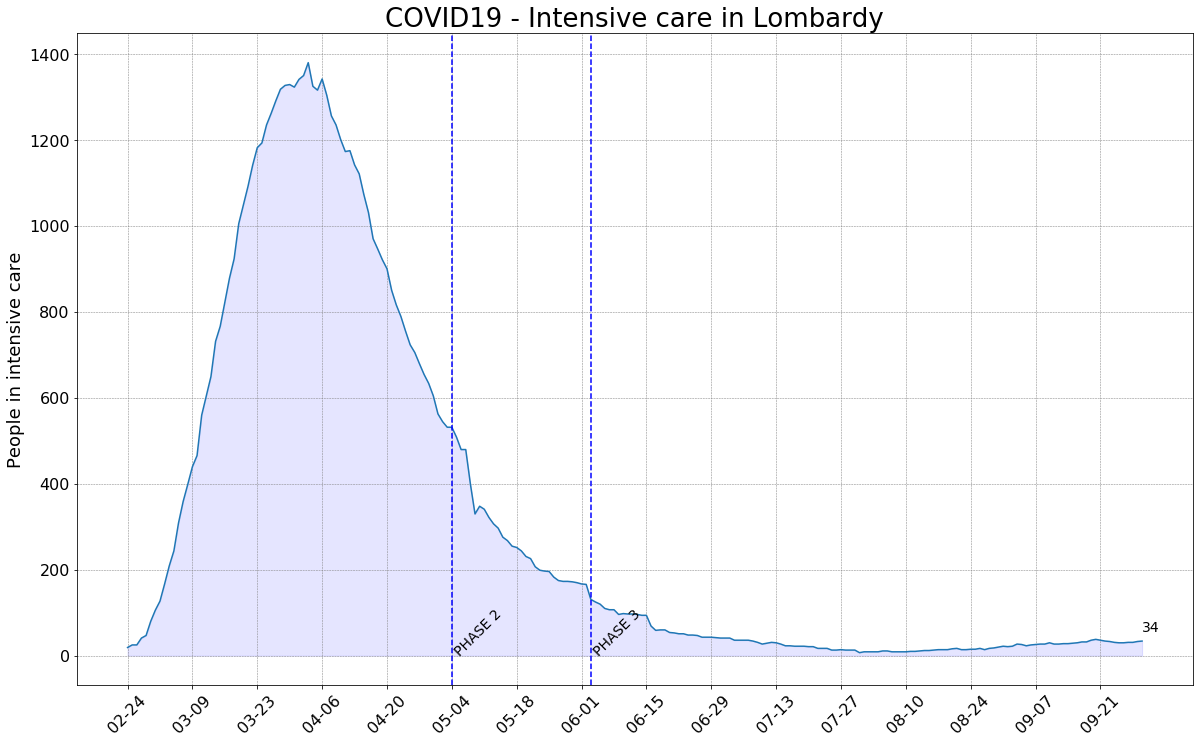

In [13]:
# Generate plot
plt.figure(figsize=(20,12))
ax = sns.lineplot(x="reference_day", y="terapia_intensiva",
                  data=df_reg)
plt.fill_between(x='reference_day', y1='terapia_intensiva', y2=0 ,data=df_reg, color='blue', alpha=.1)
plt.grid(color='grey', linestyle='--', linewidth=.5, which='both')
plt.ylabel('People in intensive care', fontsize=18)
plt.xlabel('')
plt.title('COVID19 - Intensive care in Lombardy', fontsize=26)
ax.tick_params(axis='both', which='major', labelsize=16)
plt.xticks(rotation=45)
plt.text(df_reg.reference_day[len(df_reg)-1], 
         df_reg.terapia_intensiva[len(df_reg)-1]+21,
         df_reg.terapia_intensiva[len(df_reg)-1], fontsize=14)
for day in fase2:
    ax.axvline(day, ls='--', color='blue', lw=1.5)
    plt.text(day, .3,'PHASE 2', fontsize=14, rotation=45)
for day in fase3:
    ax.axvline(day, ls='--', color='blue', lw=1.5)
    plt.text(day, .3,'PHASE 3', fontsize=14, rotation=45)
ax.set_xticks(ax.get_xticks()[::n_label])
plt.savefig(f"{dir_path}/intensive_care_lmb.png")
plt.show()